In [58]:
# Final Project: Redistricing Project of Massachutes and Oregon. 
# Class: IE 5318 Principles of Operations Reasearch
# Team Members: Natalie Ventura, Jessica Dedeaux, Damilola Fasheru
# Date: Fall 2023; 12-12-2023

# GitHub Project file: https://github.com/Jdedeaux/Districts-Counties/tree/main
# Credit to: 
#     Dr. Hamidreza Validi transportation, short path codes, and assigment codes: IE 5318 Principles of Operations Reasearch at Texas Tech University
#     Dr. Austin Buchanan districting example starter code: https://github.com/AustinLBuchanan/Districting-Examples/tree/main
#     Gurobi Optimization Tutorial via the primary website: https://www.gurobi.com/resources/lp-chapter-6-modeling-and-solving-linear-programming-problems/
    

In [59]:
# Install before. For GEOPANDAS and envioronment will need to be created within Jupyter Notebook.
# pip install gerrychain
# conda install geopandas using the terminal
# pip install geopandas

In [60]:
# MASSACHUSETTS

In [61]:
# Import the following packages to run various cells
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import geopandas as gpd
import math
import pandas as pd

<class 'networkx.classes.graph.Graph'>
The Massachusetts graph has 14 nodes
The Massachusetts graph has 24 edges
Massachusetts graph has nodes [0, 5, 13, 1, 2, 7, 12, 6, 3, 4, 11, 10, 9, 8]
Massachusetts graph has edges [(0, 5), (0, 13), (5, 1), (5, 2), (5, 13), (13, 1), (13, 7), (1, 2), (1, 7), (1, 12), (2, 6), (2, 12), (7, 3), (7, 4), (7, 10), (12, 6), (12, 9), (6, 9), (3, 4), (3, 11), (4, 10), (4, 11), (11, 10), (9, 8)]


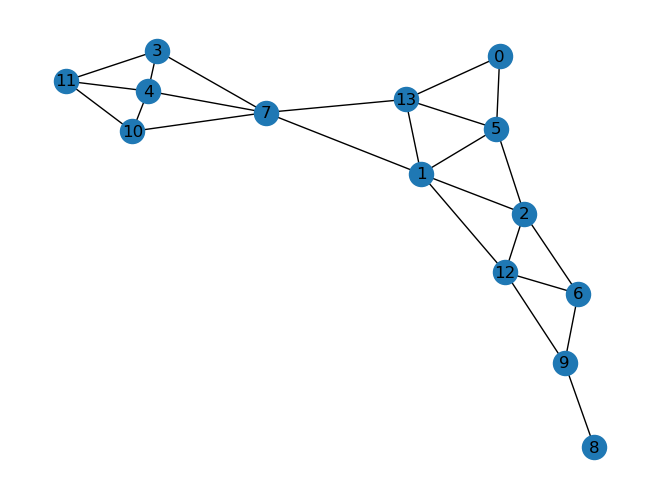

In [62]:
# Step 1: Define the edges and nodes
# Create the intial node and edges model using the edges list for Maine
# Remove the non-integers from the text file and ensure it is a plain text file.
filepath = '/Users/jessi/Gurobi-Python Playground/MA.dimacs-mod.txt'

####################
# If using the unmodified .dimacs file, it will need to be manipulated to only utilize integers. Removing column 1, row 1, last row
# filepath = "/Users/jessi/Gurobi-Python Playground/MA.dimacs"
# file = open(filepath)

# #remove the header and tail to over mixing int and str
# next(file)
# last_line = None
# for line in file:
#     if last_line:
#         for line in file:
#             if line.strip():
#                 file.write("\t".join(line.split()[1:]) + "\n")
#         print (last_line)
#         last_line = line
# # for line in file:
# #         try:
# #             r = int(line)
# #             if r > 999 or line.strip() == '-0':
# #                 #filtering numbers >999 and strings with '-0' 
# #                 continue 
# #             file.append(r)
# #         except ValueError:
# #             pass

# # Create List of integers
# # nodes_edges = []
# # for each in file:
# #     each = each.strip()
# #     #split the list so the populations in each range
# #     each = each.split(' ')
# #     print((each[1], each[2]))
# #     nodes_edges.append(int(each[1], each[2]))
#####################

# reading from the data set
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# drawing the graph
nx.draw(G, with_labels=True)

# Current model description
print("The Massachusetts graph has",G.number_of_nodes(),"nodes")
print("The Massachusetts graph has",G.number_of_edges(),"edges")
print("Massachusetts graph has nodes",G.nodes )
print("Massachusetts graph has edges",G.edges )

In [63]:
# Step 2: List the county populations
# Integrate the populations by county to the model
import gurobipy as gp
from gurobipy import GRB

#shifts = range(1,9000000)

# create population list
population = list()

# read text file into software system using files on local drive
filepath = "/Users/jessi/Gurobi-Python Playground/MA.population"
file = open( filepath,"r")

#remove the header to over mixing int and str
next(file)

#Create List
Listpop = []
for each in file:
    #split the list so the populations in each range
    each = each.split(' ')
    #print((each[1])
    Listpop.append(int(each[1]))
#displays the list of integers  
print("Massachusetts's county populations = ", Listpop)

#since the list is sorted, the sums can be taken by list position
total_population = sum(Listpop)

#print the total population of MA
print("The total_population of Massachusetts = ", total_population)
population = Listpop
n =len(population)

#print the county population as a sum districts of MA
print("Massachusetts's number of districts = ",n)

Massachusetts's county populations =  [809829, 725981, 530819, 71029, 162308, 797936, 228996, 862111, 14255, 20600, 465825, 129026, 579200, 1632002]
The total_population of Massachusetts =  7029917
Massachusetts's number of districts =  14


In [64]:
# Build the model to show which counties will be in which district
# If model is feasible, 
# create model 
m = gp.Model()

# Impose a 1% population deviation (+/- 0.5%) for the Operations Research model
deviation = 0.01
k =14

# Lower and Upper bound populations to ensure the populations of the districts do not exceed the bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

# create variables
x = m.addVars(n,k,vtype=GRB.BINARY) # x_ij equals one when county i is assigned to district j
y = m.addVar()                      # the population of least-populated district
z = m.addVar()                      # the population of most-populated district

# objective is to minimize absolute population deviation
m.setObjective(z-y,GRB.MINIMIZE)

# add constraints saying that each county i is assigned to one district
m.addConstrs(sum(x[i,j] for j in range(k)) == 1 for i in range(n))

# add constraints saying that each district has population at least y
m.addConstrs(y <= sum(population[i] * x[i,j] for i in range(n)) for j in range(k))

# add constraints saying that each district has population at most z
m.addConstrs(sum( population[i] * x[i,j] for i in range(n)) <= z for j in range(k))

# solve IP model
m.optimize()

# Match the districs to the populations per the sum of the county populations
districts = [[i for i in range(n) if x[i,j].x > 0.5] for j in range(k)]
district_populations = [sum(population[i] for i in district) for district in districts]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42 rows, 198 columns and 616 nonzeros
Model fingerprint: 0xc178d486
Variable types: 2 continuous, 196 integer (196 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3374971.0000
Presolve time: 0.00s
Presolved: 42 rows, 198 columns, 616 nonzeros
Variable types: 0 continuous, 198 integer (196 binary)

Root relaxation: objective 2.910383e-10, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   22 3374971.00    0.00000   100%     -    0s
H    0     0                    1632002.0000    0

In [65]:
# Current model status 

# print the absolute population deviation
print("The absolute population deviation is",m.objval,"person(s).")

print("Using Lower Bound of Population =",L,"and Upper Bound of Population =",U,"and districs =",k)

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",districts[j])
    
# print the optimal minization of cut edges
print("The number of cut edges is",m.objval)

The absolute population deviation is 1617747.0 person(s).
Using Lower Bound of Population = 499627 and Upper Bound of Population = 504647 and districs = 14
District 0 has population 129026 and contains counties [11]
District 1 has population 465825 and contains counties [10]
District 2 has population 1632002 and contains counties [13]
District 3 has population 862111 and contains counties [7]
District 4 has population 14255 and contains counties [8]
District 5 has population 530819 and contains counties [2]
District 6 has population 228996 and contains counties [6]
District 7 has population 797936 and contains counties [5]
District 8 has population 20600 and contains counties [9]
District 9 has population 579200 and contains counties [12]
District 10 has population 162308 and contains counties [4]
District 11 has population 725981 and contains counties [1]
District 12 has population 809829 and contains counties [0]
District 13 has population 71029 and contains counties [3]
The number o

<class 'geopandas.geodataframe.GeoDataFrame'>
14
14
Graph with 14 nodes and 24 edges
<class 'list'>


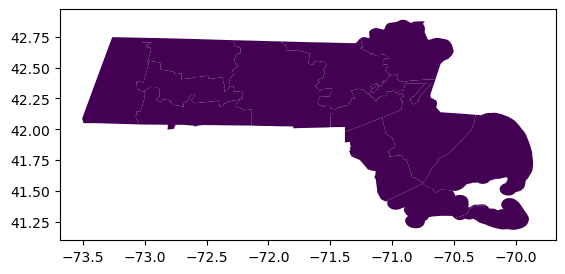

In [74]:
# Modeling the node and edges model into shape of Maine
import geopandas as gpd
filepath = '/Users/jessi/Gurobi-Python Playground/MA_distances.csv'
# Read Maine county shapefile
filepath = '/Users/jessi/Gurobi-Python Playground/MA_counties.shx'
file = '/Users/jessi/Gurobi-Python Playground/MA_counties.shp'
df =gpd.read_file(file)

print(type(df))

# Which district is each county assigned to?
# u is an iterable
assignment = [15 for u in G.nodes]
print (len(assignment))
assignment = [0 for u in G.nodes]
print (len(assignment))
exit(1);
print (G)
print(type(assignment))


# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
Massachusetts = df.plot(column='assignment').get_figure()

In [67]:
# OREGON

<class 'networkx.classes.graph.Graph'>
The Oregon graph has 36 nodes
The Oregon graph has 81 edges
Oregon graph has nodes [0, 14, 18, 22, 1, 8, 17, 2, 6, 16, 26, 29, 31, 3, 7, 24, 32, 33, 4, 11, 21, 35, 5, 9, 20, 30, 13, 19, 28, 10, 25, 27, 12, 15, 34, 23]
Oregon graph has edges [(0, 14), (0, 18), (0, 22), (14, 10), (14, 17), (14, 22), (14, 32), (18, 32), (22, 1), (22, 17), (1, 8), (1, 17), (8, 5), (8, 9), (8, 13), (8, 17), (8, 25), (8, 30), (17, 10), (17, 25), (2, 6), (2, 16), (2, 26), (2, 29), (2, 31), (6, 13), (6, 16), (6, 19), (6, 28), (6, 29), (6, 33), (16, 13), (16, 26), (16, 30), (26, 12), (26, 20), (26, 23), (26, 30), (26, 31), (26, 34), (29, 19), (31, 23), (3, 7), (3, 24), (3, 32), (3, 33), (7, 10), (7, 24), (7, 25), (7, 28), (7, 32), (24, 28), (24, 33), (32, 10), (33, 19), (33, 28), (33, 35), (4, 11), (4, 21), (4, 35), (11, 27), (11, 35), (21, 19), (21, 35), (35, 19), (35, 27), (5, 9), (5, 20), (5, 30), (20, 12), (20, 30), (30, 13), (13, 25), (13, 28), (28, 25), (10, 25), (12

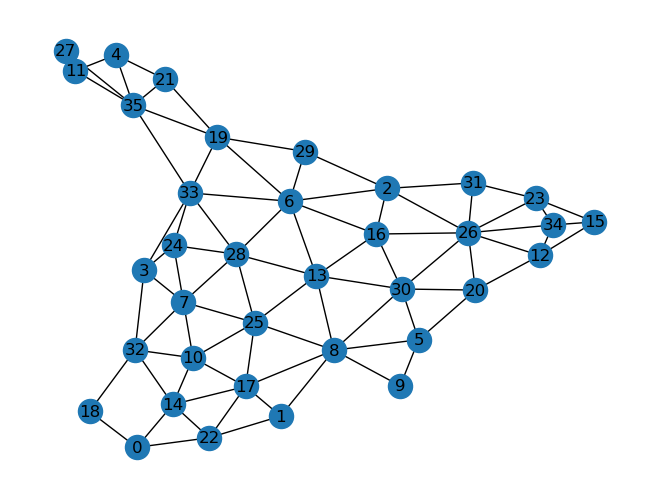

In [46]:
# Step 1: Define the edges and nodes
# Create the intial node and edges model using the edges list for Maine
# Remove the non-integers from the text file and ensure it is a plain text file.
filepath = '/Users/jessi/Gurobi-Python Playground/OR.dimacs-mod.txt'

####################
# If using the unmodified .dimacs file, it will need to be manipulated to only utilize integers. Removing column 1, row 1, last row
# filepath = "/Users/jessi/Gurobi-Python Playground/MA.dimacs"
# file = open(filepath)

# #remove the header and tail to over mixing int and str
# next(file)
# last_line = None
# for line in file:
#     if last_line:
#         for line in file:
#             if line.strip():
#                 file.write("\t".join(line.split()[1:]) + "\n")
#         print (last_line)
#         last_line = line
# # for line in file:
# #         try:
# #             r = int(line)
# #             if r > 999 or line.strip() == '-0':
# #                 #filtering numbers >999 and strings with '-0' 
# #                 continue 
# #             file.append(r)
# #         except ValueError:
# #             pass

# # Create List of integers
# # nodes_edges = []
# # for each in file:
# #     each = each.strip()
# #     #split the list so the populations in each range
# #     each = each.split(' ')
# #     print((each[1], each[2]))
# #     nodes_edges.append(int(each[1], each[2]))
#####################

# reading from the data set
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# drawing the graph
nx.draw(G, with_labels=True)

# Current model description
print("The Oregon graph has",G.number_of_nodes(),"nodes")
print("The Oregon graph has",G.number_of_edges(),"edges")
print("Oregon graph has nodes",G.nodes )
print("Oregon graph has edges",G.edges )

In [50]:
# Step 2: List the county populations
# Integrate the populations by county to the model
import gurobipy as gp
from gurobipy import GRB

#shifts = range(1,9000000)

# create population list
population = list()

# read text file into software system using files on local drive
filepath = "/Users/jessi/Gurobi-Python Playground/OR.population"
file = open( filepath,"r")

#remove the header to over mixing int and str
next(file)

#Create List
Listpop = []
for each in file:
    #split the list so the populations in each range
    each = each.split(' ')
    #print((each[1])
    Listpop.append(int(each[1]))
#displays the list of integers  
print("Oregon's county populations = ", Listpop)

#since the list is sorted, the sums can be taken by list position
total_population = sum(Listpop)

#print the total population of MA
print("The total_population of Oregon = ", total_population)
population = Listpop
n =len(population)

#print the county population as a sum districts of MA
print("Oregon's number of districts = ",n)

Oregon's county populations =  [52589, 23977, 7495, 50395, 88090, 1995, 198253, 87433, 26670, 1870, 107722, 23446, 80075, 24502, 600372, 7391, 24738, 421401, 41072, 69413, 12186, 223259, 815428, 16668, 95184, 345920, 7233, 64929, 128610, 8160, 1451, 31571, 27390, 382971, 26196, 111201]
The total_population of Oregon =  4237256
Oregon's number of districts =  36


In [51]:
# Build the model to show which counties will be in which district
# If model is feasible, 
# create model 
m = gp.Model()

# Impose a 1% population deviation (+/- 0.5%) for the Operations Research model
deviation = 0.01
k =36

# Lower and Upper bound populations to ensure the populations of the districts do not exceed the bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

# create variables
x = m.addVars(n,k,vtype=GRB.BINARY) # x_ij equals one when county i is assigned to district j
y = m.addVar()                      # the population of least-populated district
z = m.addVar()                      # the population of most-populated district

# objective is to minimize absolute population deviation
m.setObjective(z-y,GRB.MINIMIZE)

# add constraints saying that each county i is assigned to one district
m.addConstrs(sum(x[i,j] for j in range(k)) == 1 for i in range(n))

# add constraints saying that each district has population at least y
m.addConstrs(y <= sum(population[i] * x[i,j] for i in range(n)) for j in range(k))

# add constraints saying that each district has population at most z
m.addConstrs(sum( population[i] * x[i,j] for i in range(n)) <= z for j in range(k))

# solve IP model
m.optimize()

# Match the districs to the populations per the sum of the county populations
districts = [[i for i in range(n) if x[i,j].x > 0.5] for j in range(k)]
district_populations = [sum(population[i] for i in district) for district in districts]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 108 rows, 1298 columns and 3960 nonzeros
Model fingerprint: 0x8ef4c6f2
Variable types: 2 continuous, 1296 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 815428.00000
Presolve time: 0.01s
Presolved: 108 rows, 1298 columns, 3960 nonzeros
Variable types: 0 continuous, 1298 integer (1296 binary)

Root relaxation: objective 0.000000e+00, 267 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   47 815428.000    0.00000   100%     -    0s
     0     0 697726.444    0   76 8154

In [52]:
# Current model status 

# print the absolute population deviation
print("The absolute population deviation is",m.objval,"person(s).")

print("Using Lower Bound of Population =",L,"and Upper Bound of Population =",U,"and districs =",k)

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",districts[j])
    
# print the optimal minization of cut edges
print("The number of cut edges is",m.objval)

The absolute population deviation is 813977.0 person(s).
Using Lower Bound of Population = 117114 and Upper Bound of Population = 118290 and districs = 36
District 0 has population 52589 and contains counties [0]
District 1 has population 8160 and contains counties [29]
District 2 has population 87433 and contains counties [7]
District 3 has population 7391 and contains counties [15]
District 4 has population 12186 and contains counties [20]
District 5 has population 7495 and contains counties [2]
District 6 has population 27390 and contains counties [32]
District 7 has population 26670 and contains counties [8]
District 8 has population 23446 and contains counties [11]
District 9 has population 41072 and contains counties [18]
District 10 has population 421401 and contains counties [17]
District 11 has population 600372 and contains counties [14]
District 12 has population 198253 and contains counties [6]
District 13 has population 382971 and contains counties [33]
District 14 has pop

<class 'geopandas.geodataframe.GeoDataFrame'>
36
36
Graph with 36 nodes and 81 edges
<class 'list'>


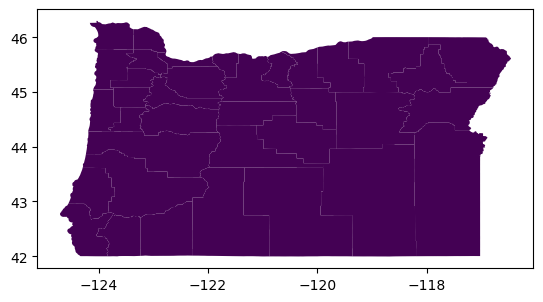

In [57]:
# Modeling the node and edges model into shape of Maine
import geopandas as gpd
filepath = '/Users/jessi/Gurobi-Python Playground/OR_distances.csv'
# Read Maine county shapefile
filepath = '/Users/jessi/Gurobi-Python Playground/OR_counties.shx'
file = '/Users/jessi/Gurobi-Python Playground/OR_counties.shp'
df =gpd.read_file(file)

print(type(df))

# Which district is each county assigned to?
# u is an iterable
assignment = [-2 for u in G.nodes]
print (len(assignment))
assignment = [-1 for u in G.nodes]
print (len(assignment))
exit(1);
print (G)
print(type(assignment))


# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
Massachusetts = df.plot(column='assignment').get_figure()